In [1]:
# If sacrebleu is not installed in your environment, uncomment:
%pip -q install sacrebleu tokenizers scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import os
import re
import time
import random

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import sacrebleu

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [2]:
CSV_PATH = "../Cleaned_data/cleaned_hieroglyphs_data.csv"

CHECKPOINT_DIR = "../best_weights/gardiner_to_english_transformer_checkpoints2"
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# training
BATCH_SIZE = 64
EPOCHS = 30
LR = 3e-4

# model
D_MODEL = 256
NHEAD = 8
NUM_LAYERS = 4
DROPOUT = 0.1

MAX_LEN = 256

# tokenizer
VOCAB_SIZE_TARGET = 100000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

print("DEVICE:", DEVICE)
print("CHECKPOINT_DIR:", CHECKPOINT_DIR)

DEVICE: cuda
CHECKPOINT_DIR: ../best_weights/gardiner_to_english_transformer_checkpoints2


In [3]:
df = pd.read_csv(CSV_PATH)

df = df.dropna(subset=["gardiner_sequence", "english_translation"]).copy()
df["gardiner_sequence"] = df["gardiner_sequence"].astype(str)
df["english_translation"] = df["english_translation"].astype(str)

train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

print("Total:", len(df))
print("Train:", len(train_df), "Val:", len(val_df))

Total: 30727
Train: 27654 Val: 3073


In [4]:
tokenizer = Tokenizer(BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(
    vocab_size=VOCAB_SIZE_TARGET,
    special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"]
)

tokenizer.train_from_iterator(
    train_df["gardiner_sequence"].tolist() + train_df["english_translation"].tolist(),
    trainer
)

PAD = tokenizer.token_to_id("<pad>")
SOS = tokenizer.token_to_id("<sos>")
EOS = tokenizer.token_to_id("<eos>")
UNK = tokenizer.token_to_id("<unk>")

VOCAB_SIZE = tokenizer.get_vocab_size()

print("Vocab size:", VOCAB_SIZE)
print("Special IDs:", {"PAD": PAD, "SOS": SOS, "EOS": EOS, "UNK": UNK})

Vocab size: 18975
Special IDs: {'PAD': 0, 'SOS': 1, 'EOS': 2, 'UNK': 3}


In [5]:
# tokenizer_path = os.path.join(CHECKPOINT_DIR, "tokenizer.json")
# tokenizer.save(tokenizer_path)
# print("Saved tokenizer to:", tokenizer_path)

In [6]:
class Seq2SeqDataset(Dataset):
    def __init__(self, df, tokenizer, sos_id, eos_id, max_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.sos = sos_id
        self.eos = eos_id
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        src_text = self.df.loc[idx, "gardiner_sequence"]
        tgt_text = self.df.loc[idx, "english_translation"]

        src_ids = self.tokenizer.encode(src_text).ids
        tgt_ids = self.tokenizer.encode(tgt_text).ids

        src_ids = [self.sos] + src_ids[: self.max_len - 2] + [self.eos]
        tgt_ids = [self.sos] + tgt_ids[: self.max_len - 2] + [self.eos]

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)


def collate_fn(batch):
    srcs, tgts = zip(*batch)
    src_lens = [len(s) for s in srcs]
    tgt_lens = [len(t) for t in tgts]

    max_src = max(src_lens)
    max_tgt = max(tgt_lens)

    src_pad = torch.full((len(batch), max_src), PAD, dtype=torch.long)
    tgt_pad = torch.full((len(batch), max_tgt), PAD, dtype=torch.long)

    for i, (s, t) in enumerate(zip(srcs, tgts)):
        src_pad[i, : len(s)] = s
        tgt_pad[i, : len(t)] = t

    return src_pad, tgt_pad

In [7]:
train_ds = Seq2SeqDataset(train_df, tokenizer, SOS, EOS, max_len=MAX_LEN)
val_ds   = Seq2SeqDataset(val_df, tokenizer, SOS, EOS, max_len=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Train batches: 433 Val batches: 49


In [8]:
def simple_detok(s: str) -> str:
    s = re.sub(r"\s+([,.!?;:])", r"\1", s)
    s = s.replace(" n't", "n't")
    s = s.replace(" 's", "'s")
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1), :]

In [10]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, pad_id):
        super().__init__()
        self.pad_id = pad_id

        self.src_embed = nn.Embedding(vocab_size, D_MODEL, padding_idx=pad_id)
        self.tgt_embed = nn.Embedding(vocab_size, D_MODEL, padding_idx=pad_id)

        self.pos_enc = PositionalEncoding(D_MODEL, max_len=MAX_LEN)

        self.transformer = nn.Transformer(
            d_model=D_MODEL,
            nhead=NHEAD,
            num_encoder_layers=NUM_LAYERS,
            num_decoder_layers=NUM_LAYERS,
            dim_feedforward=4 * D_MODEL,
            dropout=DROPOUT,
            batch_first=True
        )

        self.fc_out = nn.Linear(D_MODEL, vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        # (T, T) causal mask
        return torch.triu(torch.ones(sz, sz, device=DEVICE), diagonal=1).bool()

    def forward(self, src, tgt_in):
        # src: (B, S), tgt_in: (B, T)
        src_key_padding_mask = (src == self.pad_id)  # True where pad
        tgt_key_padding_mask = (tgt_in == self.pad_id)

        tgt_mask = self._generate_square_subsequent_mask(tgt_in.size(1))

        src_emb = self.pos_enc(self.src_embed(src))
        tgt_emb = self.pos_enc(self.tgt_embed(tgt_in))

        out = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        logits = self.fc_out(out)  # (B, T, V)
        return logits

In [11]:
def _cut_at_eos(ids, eos_id, pad_id):
    out = []
    for t in ids:
        t = int(t)
        if t == pad_id:
            continue
        if t == eos_id:
            break
        out.append(t)
    return out

In [12]:
@torch.no_grad()
def greedy_decode(model, src, sos_id, eos_id, pad_id, max_len=64):
    """
    Autoregressive greedy decoding.
    src: (B, S)
    returns: generated ids INCLUDING SOS, shape (B, <=max_len)
    """
    model.eval()
    src = src.to(DEVICE)

    B = src.size(0)
    ys = torch.full((B, 1), sos_id, dtype=torch.long, device=DEVICE)
    finished = torch.zeros(B, dtype=torch.bool, device=DEVICE)

    for _ in range(max_len - 1):
        logits = model(src, ys)                 # (B, T, V)
        next_token = logits[:, -1].argmax(-1)   # (B,)

        # if already finished, keep emitting PAD
        next_token = torch.where(
            finished,
            torch.full_like(next_token, pad_id),
            next_token
        )

        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)
        finished = finished | (next_token == eos_id)

        if finished.all():
            break

    return ys

# Training

In [15]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for src, tgt in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        # teacher forcing shift
        tgt_in = tgt[:, :-1]
        tgt_y  = tgt[:, 1:]

        optimizer.zero_grad()
        logits = model(src, tgt_in)

        loss = criterion(
            logits.reshape(-1, VOCAB_SIZE),
            tgt_y.reshape(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(1, len(loader))


@torch.no_grad()
def greedy_decode(model, src, sos_id, eos_id, pad_id, max_len=64):
    """
    Autoregressive greedy decoding.
    src: (B, S)
    returns: generated ids INCLUDING SOS, shape (B, <=max_len)
    """
    model.eval()
    src = src.to(DEVICE)

    B = src.size(0)
    ys = torch.full((B, 1), sos_id, dtype=torch.long, device=DEVICE)
    finished = torch.zeros(B, dtype=torch.bool, device=DEVICE)

    for _ in range(max_len - 1):
        logits = model(src, ys)                 # (B, T, V)
        next_token = logits[:, -1].argmax(-1)   # (B,)

        # if already finished, keep emitting PAD
        next_token = torch.where(
            finished,
            torch.full_like(next_token, pad_id),
            next_token
        )

        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)
        finished = finished | (next_token == eos_id)

        if finished.all():
            break

    return ys


@torch.no_grad()
def eval_loss_acc_and_bleu(model, loader, criterion, pad_id, sos_id, eos_id, max_decode_len=64):
    """
    - val_loss + token accuracy are computed with teacher forcing (standard, stable)
    - BLEU is computed from real autoregressive decoding (greedy)
    """
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_tokens = 0

    all_pred_texts = []
    all_gold_texts = []

    for src, tgt in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)

        # ---- loss + token acc (teacher forcing) ----
        tgt_in = tgt[:, :-1]
        tgt_y  = tgt[:, 1:]

        logits = model(src, tgt_in)

        loss = criterion(
            logits.reshape(-1, VOCAB_SIZE),
            tgt_y.reshape(-1)
        )
        total_loss += loss.item()

        preds = logits.argmax(dim=-1)
        mask = (tgt_y != pad_id)
        total_correct += (preds[mask] == tgt_y[mask]).sum().item()
        total_tokens += mask.sum().item()

        # ---- BLEU (autoregressive decoding) ----
        gen = greedy_decode(
            model=model,
            src=src,
            sos_id=sos_id,
            eos_id=eos_id,
            pad_id=pad_id,
            max_len=max_decode_len
        )

        gen_np = gen.detach().cpu().numpy()
        tgt_np = tgt.detach().cpu().numpy()

        for g_ids, t_ids in zip(gen_np, tgt_np):
            g_list = list(g_ids)
            t_list = list(t_ids)

            # drop SOS if present, then cut at EOS
            if len(g_list) > 0 and int(g_list[0]) == sos_id:
                g_list = g_list[1:]
            if len(t_list) > 0 and int(t_list[0]) == sos_id:
                t_list = t_list[1:]

            g_list = _cut_at_eos(g_list, eos_id=eos_id, pad_id=pad_id)
            t_list = _cut_at_eos(t_list, eos_id=eos_id, pad_id=pad_id)

            pred_text = simple_detok(tokenizer.decode(g_list, skip_special_tokens=True))
            gold_text = simple_detok(tokenizer.decode(t_list, skip_special_tokens=True))

            all_pred_texts.append(pred_text)
            all_gold_texts.append(gold_text)

    val_loss = total_loss / max(1, len(loader))
    avg_token_acc = (total_correct / total_tokens) if total_tokens > 0 else 0.0

    bleu = sacrebleu.corpus_bleu(
        all_pred_texts,
        [all_gold_texts],
        force=True
    ).score

    return val_loss, avg_token_acc, bleu

In [16]:
model = TransformerSeq2Seq(VOCAB_SIZE, PAD).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 21965599


In [17]:
def save_checkpoint(path, model, optimizer, epoch, train_loss, val_loss, avg_token_acc, bleu):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
        "avg_token_acc": avg_token_acc,
        "bleu": bleu,
        "special_ids": {"PAD": PAD, "SOS": SOS, "EOS": EOS, "UNK": UNK},
        "config": {
            "D_MODEL": D_MODEL,
            "NHEAD": NHEAD,
            "NUM_LAYERS": NUM_LAYERS,
            "DROPOUT": DROPOUT,
            "VOCAB_SIZE": VOCAB_SIZE,
        }
    }
    torch.save(ckpt, path)


def load_checkpoint(path, model, optimizer=None, map_location=DEVICE):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    return ckpt

In [18]:
def fmt(sec):
    sec = int(sec)
    h = sec // 3600
    m = (sec % 3600) // 60
    s = sec % 60
    if h > 0:
        return f"{h}h {m}m {s}s"
    if m > 0:
        return f"{m}m {s}s"
    return f"{s}s"


# ---- Lists to store losses and metrics per epoch ----
train_losses = []
val_losses = []
val_token_accs = []
val_bleus = []

start_all = time.time()
epoch_times = []

best_val_loss = float("inf")
best_path = None

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    val_loss, avg_token_acc, bleu = eval_loss_acc_and_bleu(
        model=model,
        loader=val_loader,
        criterion=criterion,
        pad_id=PAD,
        sos_id=SOS,
        eos_id=EOS,
        max_decode_len=64,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_token_accs.append(avg_token_acc)
    val_bleus.append(bleu)

    epoch_sec = time.time() - t0
    epoch_times.append(epoch_sec)

    elapsed_sec = time.time() - start_all
    avg_epoch = sum(epoch_times) / len(epoch_times)
    eta_sec = avg_epoch * (EPOCHS - epoch)

    ckpt_path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch:03d}.pt")
    save_checkpoint(
        ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        train_loss=train_loss,
        val_loss=val_loss,
        avg_token_acc=avg_token_acc,
        bleu=bleu,
    )

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = os.path.join(CHECKPOINT_DIR, "best.pt")
        save_checkpoint(
            best_path,
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            train_loss=train_loss,
            val_loss=val_loss,
            avg_token_acc=avg_token_acc,
            bleu=bleu,
        )

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"avg_token_acc={avg_token_acc:.4f} | "
        f"BLEU={bleu:.2f} | "
        f"epoch_time={fmt(epoch_sec)} | "
        f"elapsed={fmt(elapsed_sec)} | "
        f"ETA={fmt(eta_sec)} | "
        f"saved={ckpt_path}"
    )

print("\nTraining finished.")
print("Best checkpoint:", best_path)
print("Best validation loss:", best_val_loss)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/30 | train_loss=5.0921 | val_loss=4.2253 | avg_token_acc=0.3083 | BLEU=3.03 | epoch_time=31s | elapsed=31s | ETA=15m 1s | saved=gardiner_to_english_transformer_checkpoints2/epoch_001.pt
Epoch 2/30 | train_loss=3.9332 | val_loss=3.7719 | avg_token_acc=0.3605 | BLEU=6.93 | epoch_time=30s | elapsed=1m 1s | ETA=14m 18s | saved=gardiner_to_english_transformer_checkpoints2/epoch_002.pt
Epoch 3/30 | train_loss=3.5163 | val_loss=3.5133 | avg_token_acc=0.3943 | BLEU=7.73 | epoch_time=30s | elapsed=1m 33s | ETA=13m 49s | saved=gardiner_to_english_transformer_checkpoints2/epoch_003.pt
Epoch 4/30 | train_loss=3.2116 | val_loss=3.3302 | avg_token_acc=0.4171 | BLEU=9.56 | epoch_time=30s | elapsed=2m 4s | ETA=13m 17s | saved=gardiner_to_english_transformer_checkpoints2/epoch_004.pt
Epoch 5/30 | train_loss=2.9508 | val_loss=3.1993 | avg_token_acc=0.4359 | BLEU=10.80 | epoch_time=30s | elapsed=2m 35s | ETA=12m 46s | saved=gardiner_to_english_transformer_checkpoints2/epoch_005.pt
Epoch 6/30 | tr

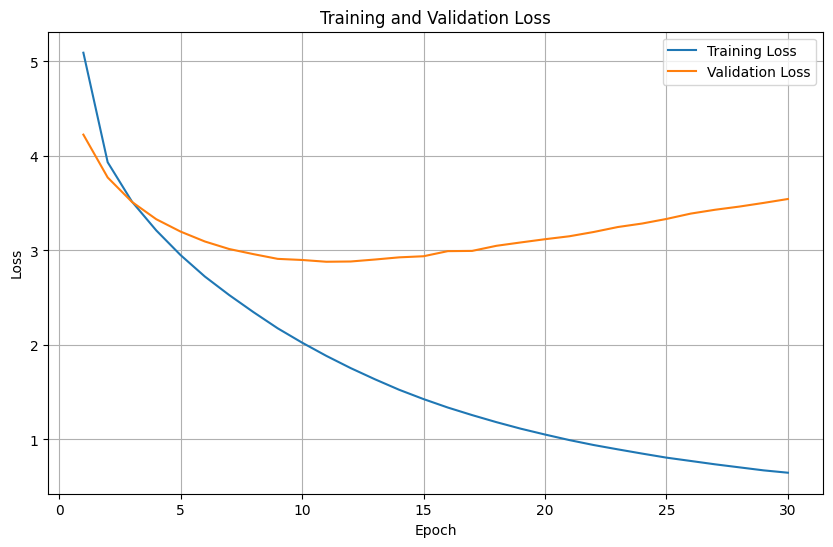

In [19]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load

In [13]:
val_df.iloc[70]['gardiner_sequence']

'N36 D21 G43 X1 Z2 V31 G36 D21 V13 N35 D36 N35 U33 M17'

In [14]:
val_df.iloc[70]['english_translation']

'the love for you is great and rich'

In [15]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file(
    os.path.join(CHECKPOINT_DIR, "tokenizer.json")
)

PAD = tokenizer.token_to_id("<pad>")
SOS = tokenizer.token_to_id("<sos>")
EOS = tokenizer.token_to_id("<eos>")

In [16]:
model = TransformerSeq2Seq(VOCAB_SIZE, PAD).to(DEVICE)

ckpt = torch.load(
    os.path.join(CHECKPOINT_DIR, "epoch_030.pt"),
    map_location=DEVICE
)
model.load_state_dict(ckpt["model_state"])
model.eval()

TransformerSeq2Seq(
  (src_embed): Embedding(18975, 256, padding_idx=0)
  (tgt_embed): Embedding(18975, 256, padding_idx=0)
  (pos_enc): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (

In [17]:
def predict(src_text, max_len=64):
    # encode source
    src_ids = tokenizer.encode(src_text).ids
    src_ids = [SOS] + src_ids + [EOS]

    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)

    # decode
    gen = greedy_decode(
        model=model,
        src=src,
        sos_id=SOS,
        eos_id=EOS,
        pad_id=PAD,
        max_len=max_len
    )

    gen_ids = gen[0].cpu().tolist()

    # drop SOS + cut at EOS
    if gen_ids and gen_ids[0] == SOS:
        gen_ids = gen_ids[1:]
    gen_ids = _cut_at_eos(gen_ids, EOS, PAD)

    return tokenizer.decode(gen_ids, skip_special_tokens=True)

In [18]:
src = "N36 D21 G43 X1 Z2 V31 G36 D21 V13 N35 D36 N35 U33 M17"
translation = predict(src)

print("SOURCE:", src)
print("ACTUAL:",val_df.iloc[70]['english_translation'])
print("PREDICTION:", translation)

d:\projects\hieroglyphics_project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


SOURCE: N36 D21 G43 X1 Z2 V31 G36 D21 V13 N35 D36 N35 U33 M17
ACTUAL: the love for you is great and rich
PREDICTION: the love for you is great and abundant
